In [1]:
kaggle=False
kaggle_path='/kaggle/input/nlp-getting-started/train.csv'
local_path='train.csv'

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torchtext
import pandas as pd
import time
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


In [2]:

df=pd.read_csv(kaggle_path if kaggle else local_path)
df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<Axes: >

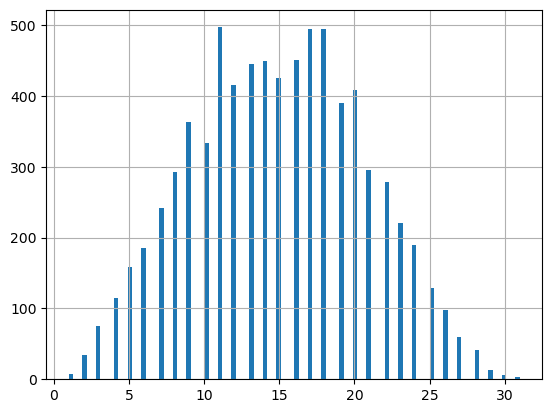

In [3]:
# count the number of words and plot a histogram
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['word_count'].hist(bins=100)


In [4]:
# label encoding of keyword using sklearn
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['keyword'] = le.fit_transform(df['keyword'].fillna(''))
df['keyword'].sample(5)

1707     50
3212     93
4980    145
2639     76
514      14
Name: keyword, dtype: int64

In [5]:
df['keyword'].nunique()

222

In [6]:
df.target.unique()

array([1, 0])

In [7]:
df.sample(20)

,id,keyword,location,text,target,word_count
4367,6202,126,USA,How to remove http://t.co/HRSfA8zujI BrowseråÊ...,0,7
7201,10316,211,NaN,only weapon im scared off is karma,0,7
5107,7286,148,NaN,The president spoke of Kennedy's diplomacy to ...,1,22
3588,5126,104,"Fresno, CA",@ChrisDanielShow Nearly-Fatal Pee in San Franc...,0,7
6466,9250,189,NaN,@aphyr IÛªve been following you this longÛ_ ...,0,12
5590,7977,163,NaN,The Latest: More homes razed by Northern Calif...,1,12
4811,6848,139,NaN,I don't laugh out loud at many things. But man...,0,18
3386,4848,98,Yellowknife,ÛÏA voluntary evacuation is being recommended...,1,22
951,1378,27,"Manchester, The World, England",@anarchic_teapot @BoironUSA @zeno001 Glononium...,0,20
953,1380,28,New York,New Ladies Shoulder Tote Handbag Women Cross B...,0,18


In [8]:
import spacy
nlp = spacy.load('en_core_web_sm')

# Tokenizer-Funktion
def tokenizer(text):
    # use spacey for tokenization
    return [tok.text for tok in nlp.tokenizer(text)]

# Vokabular erstellen
def build_vocab(texts, vocab_size=None):
    word_to_idx = {}
    for text in texts:
        tokens = tokenizer(text)
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = len(word_to_idx)
    if vocab_size is not None:
        word_to_idx = {k: v for k, v in sorted(word_to_idx.items(), key=lambda item: item[1])[:vocab_size]}
    return word_to_idx

# Texte in Sequenzen von Wortindizes umwandeln
def text_to_indices(text, word_to_idx):
    tokens = tokenizer(text)
    indices = [word_to_idx[token] if token in word_to_idx else 0 for token in tokens]
    return indices

num_epochs = 2

# Aufteilung in Trainings- und Testdaten
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Erstellung des Vokabulars
texts = train_df['text'].tolist()
word_to_idx = build_vocab(texts, vocab_size=10000)
vocab_size=len(word_to_idx)
print("vocab size:", vocab_size)

vocab size: 10000


In [9]:
def text_pipeline(x):                           
    return text_to_indices(x, word_to_idx)

text_pipeline("This is a test sentence")

[1636, 98, 24, 9216, 0]

In [10]:
class DisasterTweetsDataset(Dataset):
    def __init__(self, df, vocab_size=10000, test=False):
        self.df = df
        self.vocab_size = vocab_size
        self.test = test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x= self.df.iloc[idx]["text"]
        keyword = self.df.iloc[idx]["keyword"]
        if not self.test:
            y= self.df.iloc[idx]["target"]
            y = int(y)
            y= torch.tensor(y, dtype=torch.long)
        x = text_pipeline(x)
        x = torch.tensor(x)
        keyword = torch.tensor(keyword, dtype=torch.long)
        if not self.test:
            return x, keyword, y
        return x, keyword
    
disaster_tweets_dataset = DisasterTweetsDataset(df, vocab_size=vocab_size)
x, keyword, y=disaster_tweets_dataset[378]
print(x)
print(keyword)
print(y)

tensor([158, 159, 160, 105, 161, 119, 162, 163, 164,  13, 165, 166,   0])
tensor(10)
tensor(0)


In [11]:

sequence_length = 30

def collate_batch(batch):
    x, keyword, y = zip(*batch)
    x = [torch.tensor(text, dtype=torch.long) for text in x]
    empty_dummy_for_fixed_length = torch.zeros(sequence_length, dtype=torch.long)
    x = torch.stack([torch.cat((text, empty_dummy_for_fixed_length))[:sequence_length] for text in x])
    y = torch.stack(y)
    keywords=torch.stack(keyword)
    return x, keywords, y


# test custom collate function

print("Tweet 0:'", df.iloc[1].text, "' |  target", df.iloc[0].target)
print("Tweet 1:'", df.iloc[1].text, "' |  target", df.iloc[1].target)
print(collate_batch([disaster_tweets_dataset[0], disaster_tweets_dataset[1]]))

Tweet 0:' Forest fire near La Ronge Sask. Canada ' |  target 1
Tweet 1:' Forest fire near La Ronge Sask. Canada ' |  target 1
(tensor([[  71,    0,  866,   44, 7906,    4,  110,   13, 2904, 2090,    0,    0,
          227,  343,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [ 439,  495,  554, 2356,    0,    0,   12, 8618,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]]), tensor([0, 0]), tensor([1, 1]))


/var/folders/yl/qjs6b9wn4zx7nh630c4my9lw0000gn/T/ipykernel_91274/790357553.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = [torch.tensor(text, dtype=torch.long) for text in x]


In [12]:


from torch import nn
import torch.nn.init as init
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class TextClassificationModel(nn.Module):

    def __init__(self, 
                 vocab_size=None, 
                 transformer_embedding_dim=None,  
                 transformer_feedforward_dim=None,
                 num_class= None, 
                 keywords_size=30, 
                 keyword_embedding_dim=4, 
                 attention_head_number=4,
                 num_transformer_layers=2,
                 hidden_size=100,
                 sequence_length=30,
                 dropout=0.5):
        
        super(TextClassificationModel, self).__init__()
        self.transformer_embedding_dim=transformer_embedding_dim
        self.embedding = nn.Embedding(vocab_size, transformer_embedding_dim)
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=transformer_embedding_dim,
            nhead=attention_head_number,  
            dim_feedforward=transformer_feedforward_dim,
        )
        self.pos_encoder = PositionalEncoding(transformer_embedding_dim, dropout)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_transformer_layers)
        self.keywords_embedding = nn.Embedding(keywords_size, keyword_embedding_dim)
        self.fc1 = nn.Linear(sequence_length*transformer_embedding_dim+keyword_embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2= nn.Linear(hidden_size, num_class)
        self.batch_norm1 = nn.BatchNorm1d(sequence_length*transformer_embedding_dim+keyword_embedding_dim)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.relu=nn.ReLU()
        self.init_weights()
        

    def init_weights(self):
        initrange = 0.5
        # uniform initialisation for the embedding layer
        self.embedding.weight.data.uniform_(-initrange, initrange)
        #self.fc.weight.data.uniform_(-initrange, initrange)
        #self.fc.bias.data.zero_()
        
        # He initialisation for the weights of the fully connected layer
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.data.fill_(0.0)

    def forward(self, text, keywords):
        #print("text shape: ", text.shape)
        embedded = self.embedding(text)* math.sqrt(self.transformer_embedding_dim)
        embedded=self.pos_encoder(embedded)
        #print("embedded shape: ", embedded.shape)
        embedded = embedded.permute(1, 0, 2)  # Shape: (word_count, batch_size, embedding_dim)
        #print("embedded 2 shape: ", embedded.shape)
        transformer_output = self.transformer(embedded)
        #print("transformer_output 1 shape: ", transformer_output.shape)
        transformer_output = transformer_output.permute(1, 0, 2)  # Back to (batch_size, word_count, embedding_dim)
        #print("transformer_output 2 shape: ", transformer_output.shape)
        transformer_output = transformer_output.contiguous().view(transformer_output.size(0), -1)
        #print("transformer_output  3 shape: ", transformer_output.shape)
        keywords_embedded = self.keywords_embedding(keywords)
        #print("keywords_embedded shape: ", keywords_embedded.shape)
        embedded = torch.cat((transformer_output, keywords_embedded), dim=1)
        #print("embedded.shape"  , embedded.shape)
        out=self.batch_norm1(embedded)
        out=self.dropout(out)
        out=self.fc1(out)
        out=self.batch_norm2(out)
        out=self.dropout(out)
        out=self.relu(out)
        return self.fc2(out)


# test all together
df_to_test=df.sample(10)
dataset_to_test = DisasterTweetsDataset(df_to_test, vocab_size=vocab_size)
dataloader_to_test = DataLoader(dataset_to_test, batch_size=4, shuffle=True, collate_fn=collate_batch)
model=TextClassificationModel(
    vocab_size=vocab_size,
    transformer_embedding_dim=32,
    transformer_feedforward_dim=64,
    keyword_embedding_dim=10, 
    attention_head_number=4,
    num_transformer_layers=6,
    hidden_size=100,
    num_class=2, 
    keywords_size=df.keyword.nunique())
for x, keywords, y in dataloader_to_test:
    print("x: ", x)
    print("keywords: ", keywords)
    print("y: ", y)
    print("model output: " , model(x, keywords))
    print("End Batch\n\n\n")

x:  tensor([[   0,  235,  569,  617, 4455,   24, 5639,  235,  847,  322,   85, 4869,
            0,   44,    0,   85,  235, 3757,  597,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [9549,   98,   44, 2519,  319, 1343, 2800,   13,    0,   64,   64,   64,
           64,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [1330,    0,    6, 3941,   44, 2519,   44,  786, 4716,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0],
        [   0, 3069,    0,   41,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]])
keywords:  tensor([157,   9,  31,  98])
y:  tensor([0, 0, 1, 1])
model output:  tensor([[-0.6560, -0.2053],
        [ 0.4730,  0.7377],
        [-3.5353,  1.9592],

/var/folders/yl/qjs6b9wn4zx7nh630c4my9lw0000gn/T/ipykernel_91274/790357553.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = [torch.tensor(text, dtype=torch.long) for text in x]


In [17]:
class Learner():
    
    def __init__(self, model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_func, device):
        self.model=model
        self.device=device
        self.model=self.model.to(self.device)
        self.train_dataloader=train_dataloader
        self.valid_dataloader=valid_dataloader
        self.optimizer=optimizer
        self.scheduler=scheduler
        self.loss_func=loss_func
        self.accu_train=[]
        self.accu_valid=[]

    def evaluate(self, loader):
        model.eval()
        total_acc, total_count = 0, 0
        with torch.no_grad():
            for idx, (x, keywords, y) in enumerate(loader):
                x=x.to(self.device)
                keywords=keywords.to(self.device)
                y=y.to(self.device)
                predicted_label = model(x, keywords)
                total_acc += (predicted_label.argmax(1) == y).sum().item()
                total_count += y.size(0)
        return total_acc/total_count


    def fit_one_epoch(self):
        epoch_start_time = time.time()
        self.model.train()

        for idx, (x, keywords, y) in enumerate(self.train_dataloader):
            self.optimizer.zero_grad()
            x=x.to(self.device)
            y=y.to(self.device)
            keywords=keywords.to(self.device)
            predicted_label = model(x, keywords)
            loss = self.loss_func(predicted_label, y)
            loss.backward()
            self.optimizer.step()

        accu_train = self.evaluate(self.train_dataloader)
        accu_valid = self.evaluate(self.valid_dataloader)
        self.accu_train.append(accu_train)
        self.accu_valid.append(accu_valid)
        self.scheduler.step() 
        return (time.time() - epoch_start_time)

    def fit_epochs(self, number=None):
        bar=tqdm(range(number)) if number else range(number)
        for epoch in bar:
            epoch_time=self.fit_one_epoch()
            #print('-' * 59)
            #print('| end of epoch {:3d} | time: {:5.2f}s | train accuracy {:8.3f} | valid accuracy {:8.3f} | lr: {:1.2f}'.format(
            #                            epoch,
            #                            epoch_time,
            #                            self.accu_train[-1],
            #                            self.accu_valid[-1],
            #                            self.scheduler.get_last_lr()[0]))    
            bar.set_description('Epoch: {} - accu_train: {:8.3f} - accu_valid: {:8.3f}'.format(epoch, self.accu_train[-1], self.accu_valid[-1]))

    def plot_training(self):
        plt.plot(self.accu_train, label="train accuracy")
        plt.plot(self.accu_valid, label="valid accuracy")
        plt.legend()
        plt.show()

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if kaggle==False:
    device = torch.device("cpu")



# Hyperparameters
LR = 0.001  # learning rate
BATCH_SIZE = 256 # batch size for training


model = TextClassificationModel(
    vocab_size=vocab_size,
    transformer_embedding_dim=512,
    transformer_feedforward_dim=2048,
    keyword_embedding_dim=30, 
    attention_head_number=8,
    num_transformer_layers=4,
    hidden_size=75,
    num_class=2, 
    keywords_size=df.keyword.nunique())

train_dataset=DisasterTweetsDataset(train_df, vocab_size=vocab_size)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataset=DisasterTweetsDataset(test_df, vocab_size=vocab_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)

loss_func = torch.nn.CrossEntropyLoss()
#
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10.0, gamma=0.9)   # every 3 epochs, LR is multiplied by 0.7
# cosine scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=0.0001)

learner=Learner(model, train_dataloader, valid_dataloader, optimizer, scheduler, loss_func, device)

  0%|          | 0/24 [00:00<?, ?it/s]

/var/folders/yl/qjs6b9wn4zx7nh630c4my9lw0000gn/T/ipykernel_91274/790357553.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = [torch.tensor(text, dtype=torch.long) for text in x]


-----------------------------------------------------------
| end of epoch   0 | time: 39.51s | train accuracy    0.589 | valid accuracy    0.582 | lr: 0.00


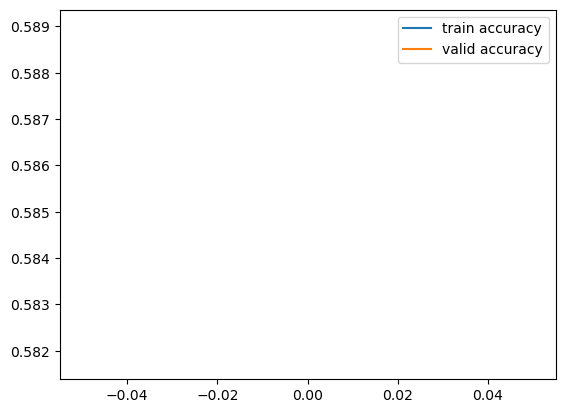

In [19]:
learner.fit_epochs(1)
learner.plot_training()

  0%|          | 0/24 [00:00<?, ?it/s]

/var/folders/yl/qjs6b9wn4zx7nh630c4my9lw0000gn/T/ipykernel_91274/790357553.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = [torch.tensor(text, dtype=torch.long) for text in x]


-----------------------------------------------------------
| end of epoch   0 | time: 39.51s | train accuracy    0.569 | valid accuracy    0.574 | lr: 0.00


  0%|          | 0/24 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   1 | time: 39.11s | train accuracy    0.588 | valid accuracy    0.584 | lr: 0.00


  0%|          | 0/24 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   2 | time: 39.96s | train accuracy    0.431 | valid accuracy    0.426 | lr: 0.00


  0%|          | 0/24 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   3 | time: 41.41s | train accuracy    0.613 | valid accuracy    0.624 | lr: 0.00


  0%|          | 0/24 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   4 | time: 41.35s | train accuracy    0.723 | valid accuracy    0.709 | lr: 0.00


  0%|          | 0/24 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   5 | time: 39.58s | train accuracy    0.733 | valid accuracy    0.710 | lr: 0.00


  0%|          | 0/24 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   6 | time: 39.64s | train accuracy    0.736 | valid accuracy    0.712 | lr: 0.00


  0%|          | 0/24 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   7 | time: 39.99s | train accuracy    0.712 | valid accuracy    0.676 | lr: 0.00


  0%|          | 0/24 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   8 | time: 41.02s | train accuracy    0.805 | valid accuracy    0.756 | lr: 0.00


  0%|          | 0/24 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   9 | time: 42.07s | train accuracy    0.806 | valid accuracy    0.743 | lr: 0.00


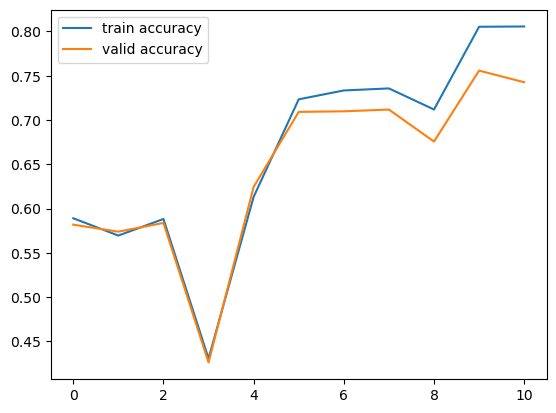

In [20]:
learner.fit_epochs(10)
learner.plot_training()

/var/folders/yl/qjs6b9wn4zx7nh630c4my9lw0000gn/T/ipykernel_74963/2206214718.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = [torch.tensor(text, dtype=torch.long) for text in x]


-----------------------------------------------------------
| end of epoch   0 | time: 20.06s | train accuracy    0.783 | valid accuracy    0.726 | lr: 0.00
-----------------------------------------------------------
| end of epoch   1 | time: 19.88s | train accuracy    0.784 | valid accuracy    0.717 | lr: 0.00
-----------------------------------------------------------
| end of epoch   2 | time: 19.90s | train accuracy    0.793 | valid accuracy    0.720 | lr: 0.00
-----------------------------------------------------------
| end of epoch   3 | time: 19.68s | train accuracy    0.803 | valid accuracy    0.739 | lr: 0.00
-----------------------------------------------------------
| end of epoch   4 | time: 20.04s | train accuracy    0.798 | valid accuracy    0.731 | lr: 0.00
-----------------------------------------------------------
| end of epoch   5 | time: 19.83s | train accuracy    0.810 | valid accuracy    0.752 | lr: 0.00
----------------------------------------------------------

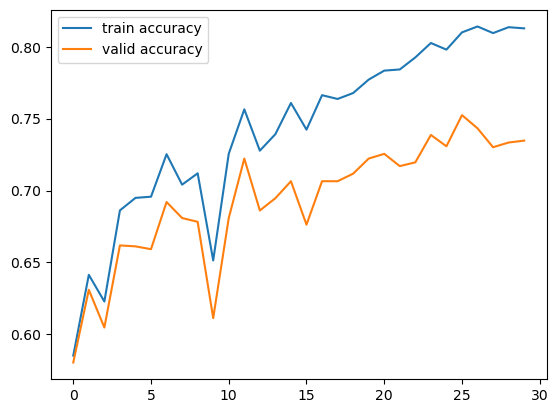

In [ ]:
learner.fit_epochs(10)
learner.plot_training()

In [ ]:
local_test_path='test.csv'
kaggle_test_path='/kaggle/input/nlp-getting-started/test.csv'

df_submission_test_data=pd.read_csv(kaggle_test_path if kaggle else local_test_path)
df_submission_test_data.sample(5)

,id,keyword,location,text
2033,6838,loud%20bang,NaN,School Bouta Start: \n\nBack To These Ignorant...
834,2742,crushed,"Ottawa, ON, Canada",@Loraccee @JoeNBC @msnbc Still gets crushed by...
2407,8052,refugees,lbtidronegirlshell,Still wonder why they will do anything to have...
1018,3348,demolished,Connecticut,That ball was fucking demolished
294,954,blaze,Texas,I liked a @YouTube video from @ashens http://t...


In [ ]:
# label encode keyword using trained label encoder
df_submission_test_data['keyword'] = le.transform(df_submission_test_data['keyword'].fillna(''))

In [ ]:
def collate_batch_test_data(batch):
    x, keywords = zip(*batch)
    # collate for embedding bag
    empty_dummy_for_fixed_length = torch.zeros(sequence_length, dtype=torch.long)
    x = torch.stack([torch.cat((text, empty_dummy_for_fixed_length))[:sequence_length] for text in x])
    keywords=torch.stack(keywords)
    return x, keywords

In [ ]:
model.eval()
preds=[]
test_dataset=DisasterTweetsDataset(df_submission_test_data, vocab_size=vocab_size, test=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch_test_data)
with torch.no_grad():
    for idx, (x, keywords) in enumerate(test_dataloader):
        x=x.to(device)
        keywords=keywords.to(device)
        predicted_label = model(x, keywords)
        preds.extend(predicted_label.argmax(1).tolist())

df_submission_test_data["target"]=preds
df_submission_test_data[["id", "target"]].to_csv("submission_04.csv", index=False)

In [ ]:
# Score: 0.76861